<a href="https://colab.research.google.com/github/ekaterina-kozh/SQL_EX/blob/main/segment_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучи U-net подобную архитектуру сегментировать легкие человека на радиографическом снимке. Используй данные о нормальном состоянии легких в папке covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.

In [ ]:
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from skimage import measure

import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел
                                                                                     # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kozhevnikova11
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:24<00:00, 33.3MB/s]


Выведем пример наших файлов оригинал и маски.

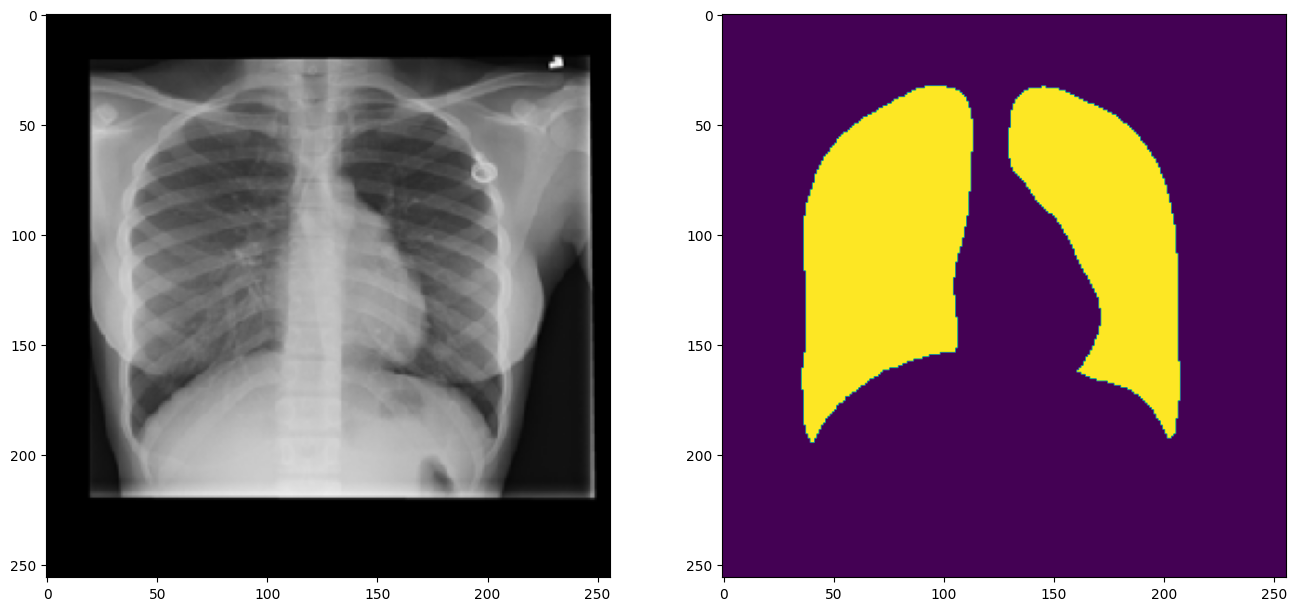

In [ ]:
from keras.preprocessing.image import  load_img
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()

original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [ ]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

batch_size = 32
img_size = (256, 256)
num_classes  = NUM_CLASSES = 2

In [ ]:
# Генератор для перебора данных (в виде массивов Numpy)
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.num_classes = num_classes
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, self.num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255 # нормализуем изображение
            y[_] = to_categorical(mask / 255, num_classes=self.num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y

In [ ]:
import random

seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

percent = 10 # процент расщепления validation

val_samples = len(input_img_path) * percent // 100
lan = val_samples + 100

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:val_samples]
train_target_img_path = target_img_path[:val_samples]
val_input_img_path = input_img_path[val_samples:lan]
val_target_img_path = target_img_path[val_samples:lan]

In [ ]:
len(train_input_img_path)

1019

In [ ]:
input_img_path = None
target_img_path = None

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)
val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation=True)

In [ ]:
#x, y = train_gen[0]
#print(x.shape, y.shape)

In [ ]:
#x1, y1 = val_gen[0]
#print(x1.shape, y1.shape)

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

# Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

In [ ]:
# Наша интерпретация модели U-net
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышка задаем 2-мя синими блоками
    conv_block = convolution_operation(encoder_4, 64*16)

    # Задаем блоки декодировщика и передаем ему латеральные соединения от кодировщиков
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (1, 1), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
num_classes = NUM_CLASSES # 2 класса объектов
input_shape = (img_size[0], img_size[1], 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, num_classes) # инициализируем модель

In [ ]:
model.compile(
    optimizer='adam' ,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]
model.summary() # отчет о структуре модели

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ re_lu_19[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 128)  │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ re_lu_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 128)  │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_21 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ re_lu_21[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├──────────────────────

 Total params: 31,055,362 (118.47 MB)

 Trainable params: 31,043,586 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

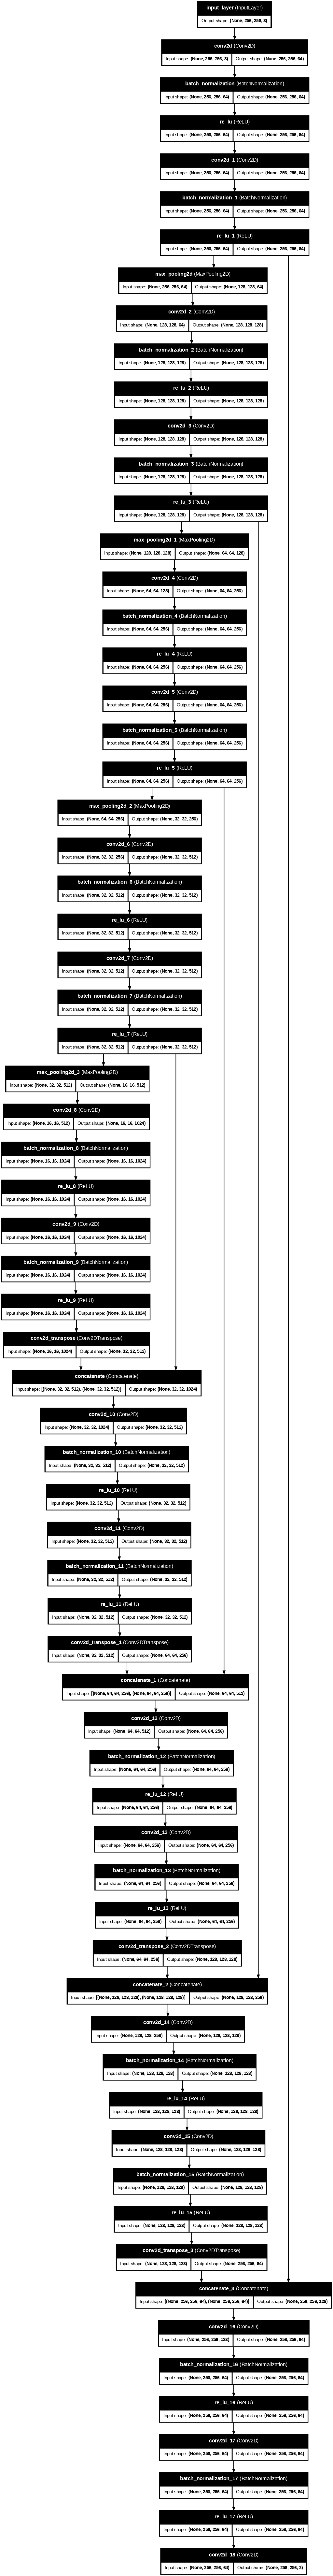

In [ ]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

In [ ]:
type(val_gen)

__main__.datasetGenerator

In [ ]:
type(train_gen)

__main__.datasetGenerator

In [ ]:
epochs = 10
#steps_per_epoch = len(train_gen) // batch_size
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    #steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks
                   )

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9866 - loss: 0.0372

<ipython-input-6-10c626bca63b>:43: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали


31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9866 - loss: 0.0372 - val_accuracy: 0.8340 - val_loss: 0.4728
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9890 - loss: 0.0294 - val_accuracy: 0.7543 - val_loss: 0.9951
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9909 - loss: 0.0243 - val_accuracy: 0.7577 - val_loss: 0.9233
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9911 - loss: 0.0231 - val_accuracy: 0.7755 - val_loss: 0.8547
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9889 - loss: 0.0292 - val_accuracy: 0.8241 - val_loss: 0.5389
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9912 - loss: 0.0227 - val_accuracy: 0.7624 - val_loss: 1.4061
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9911 - loss: 0.0227 - val_accuracy: 0.7768 - val_loss: 1.0596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9928 - loss: 0.0182 - val_accuracy: 0.7572 - val_loss: 1.5226
Epo

In [ ]:
best_val_accuracy = max(history.history['val_accuracy'])
print(f'Лучший результат val_accuracy: {best_val_accuracy} для проверочной выборки')

Лучший результат val_accuracy: 0.8867074847221375 для проверочной выборки


In [ ]:
best_val_accuracy = max(history.history['accuracy'])
print(f'Лучший результат accuracy: {best_val_accuracy} для обучающей выборки')

Лучший результат accuracy: 0.9922731518745422 для обучающей выборки


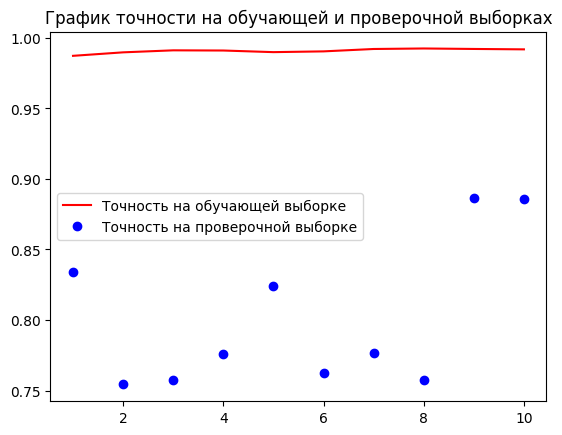

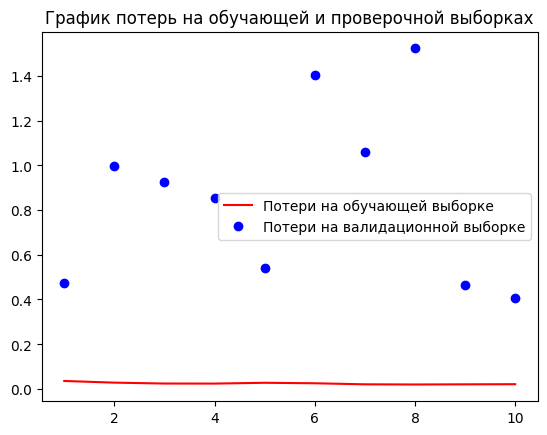

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


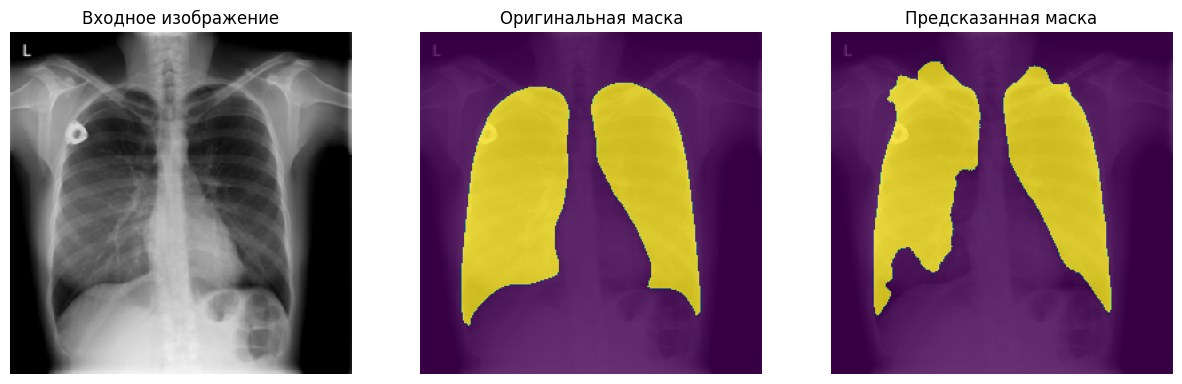

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


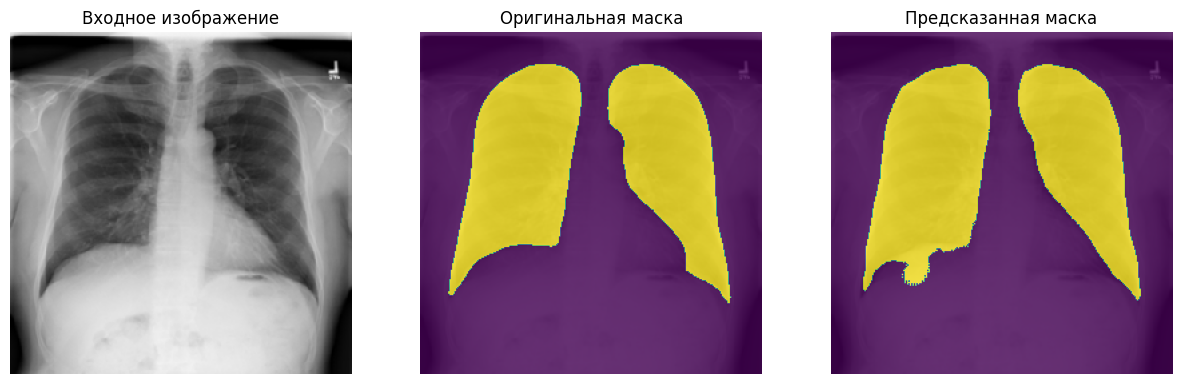

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


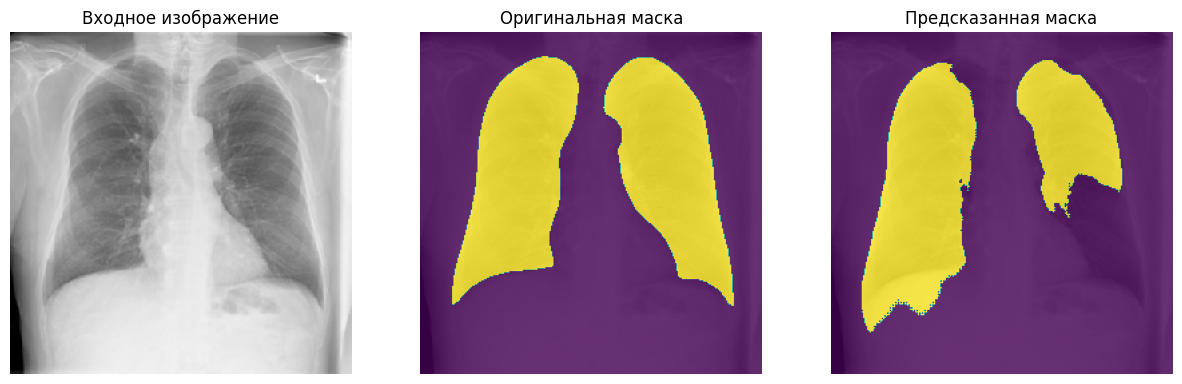

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


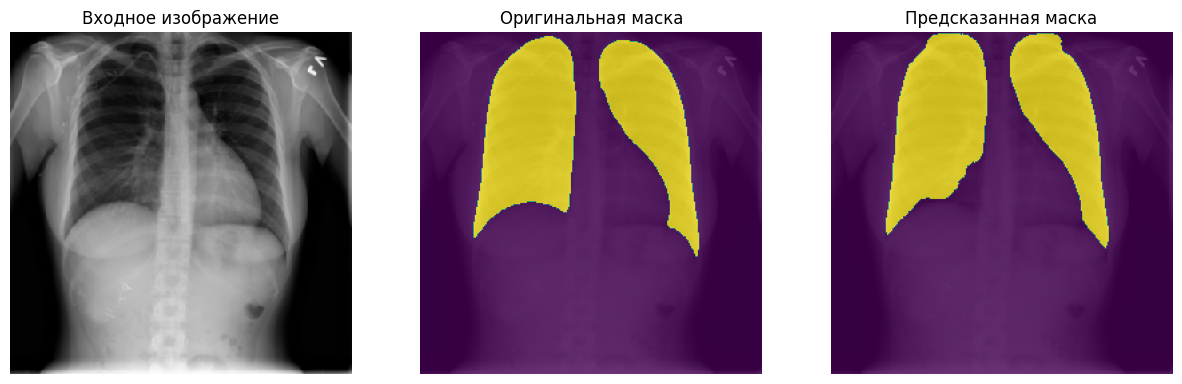

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


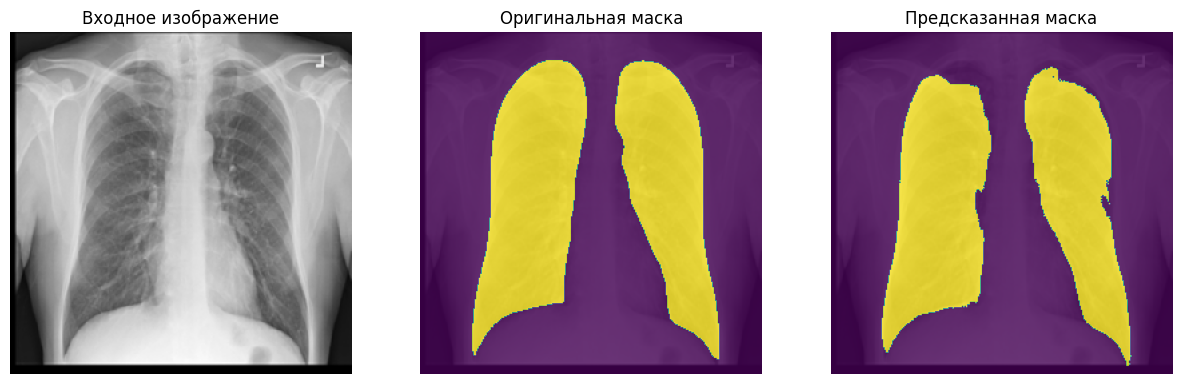

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


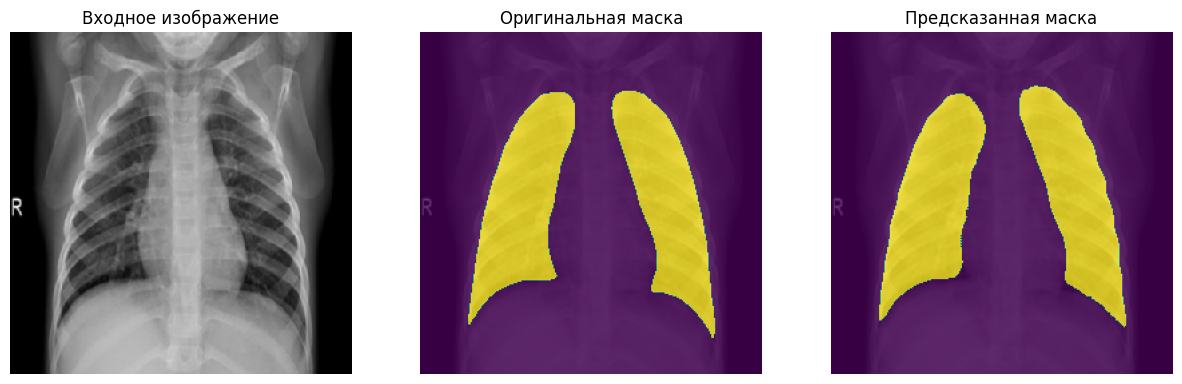

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


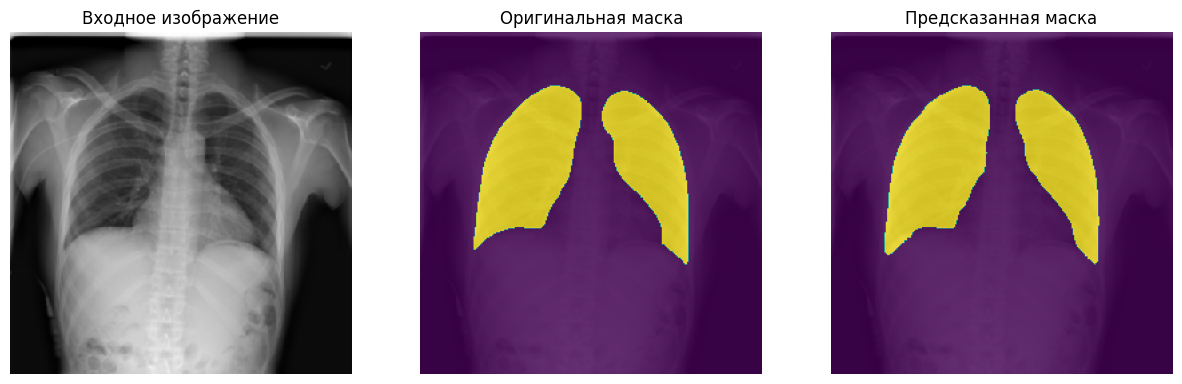

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


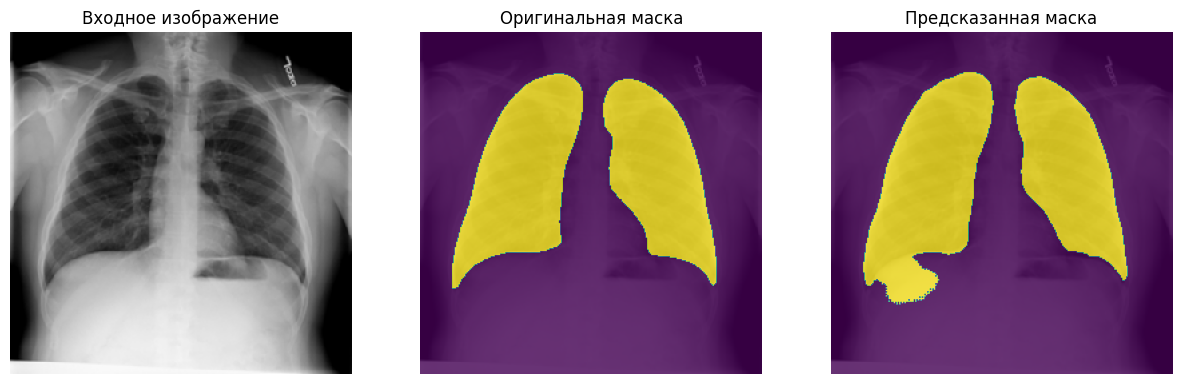

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


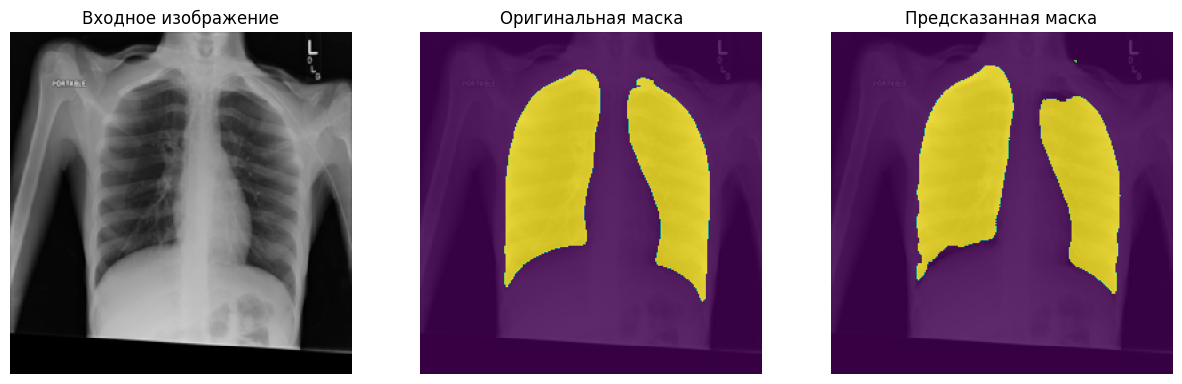

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


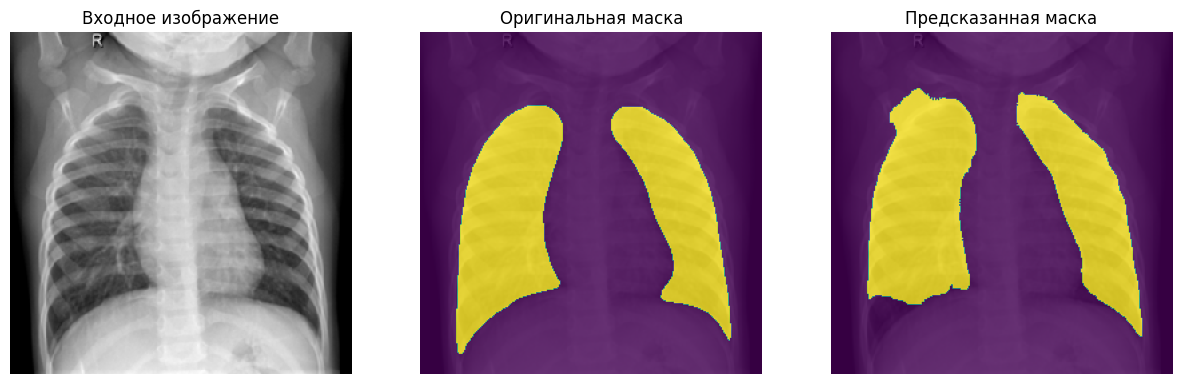

In [ ]:
for index in range(10):                  # выбираем 10 картинок и выводим их в цикле
    img = np.array(load_img(val_input_img_path[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную